# CASE 1: Forecasting Weekly Demand for a Soft Drink Product – A Time Series Modeling Challenge

In [115]:
# Basic necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math # For sqrt if calculating RMSE manually

# Time Series Specific Libraries from statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA # As one of the alternative models
from statsmodels.tsa.holtwinters import ExponentialSmoothing # As another alternative model

# Model Evaluation Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Settings
warnings.filterwarnings("ignore")
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 7)

## Part A: Data Preparation & Exploration


Preprocessing complete. Final data shape: (1983, 5)

Preprocessed data head:
                      DEMAND  HOUR  DAY_OF_WEEK_NUM DAY_OF_WEEK_NAME DAY_TYPE
2005-03-01 06:30:00     1.0     6                1          Tuesday  Weekday
2005-03-01 06:45:00     2.0     6                1          Tuesday  Weekday
2005-03-01 07:00:00     4.0     7                1          Tuesday  Weekday
2005-03-01 07:15:00     0.0     7                1          Tuesday  Weekday
2005-03-01 07:30:00    10.0     7                1          Tuesday  Weekday


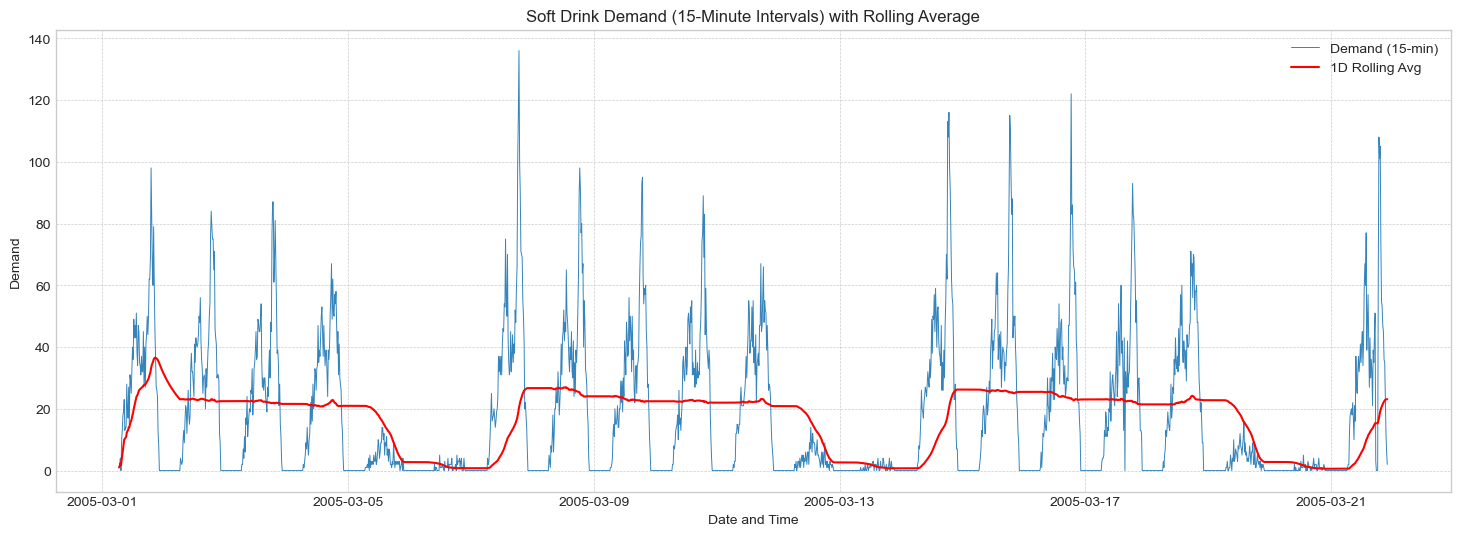

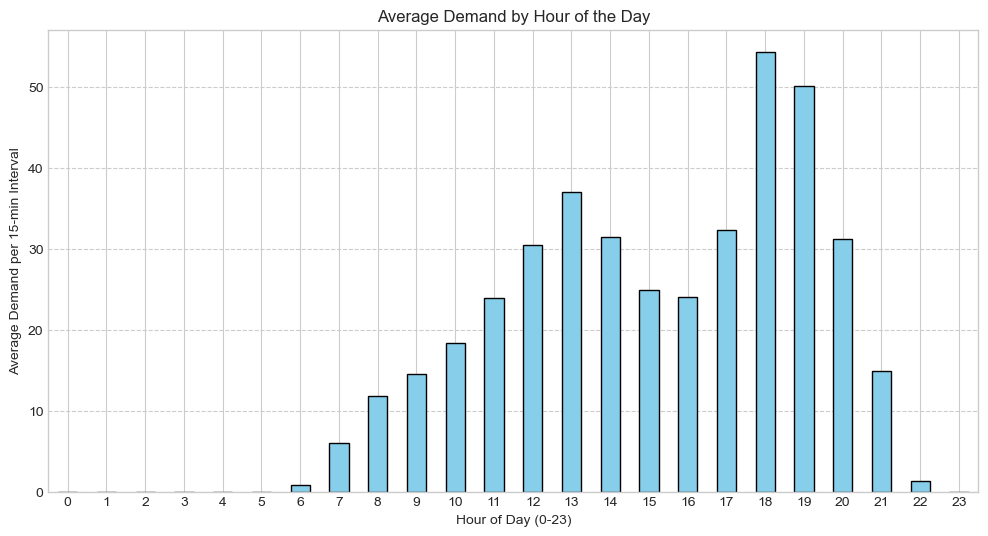

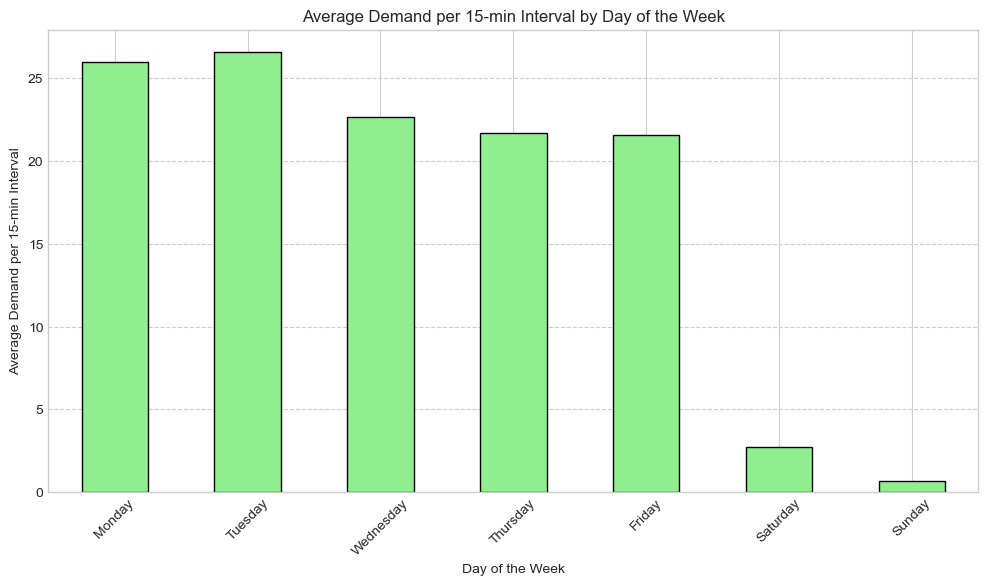

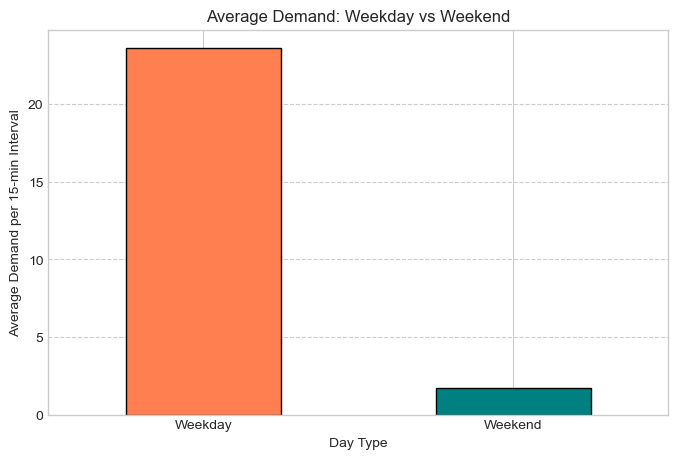

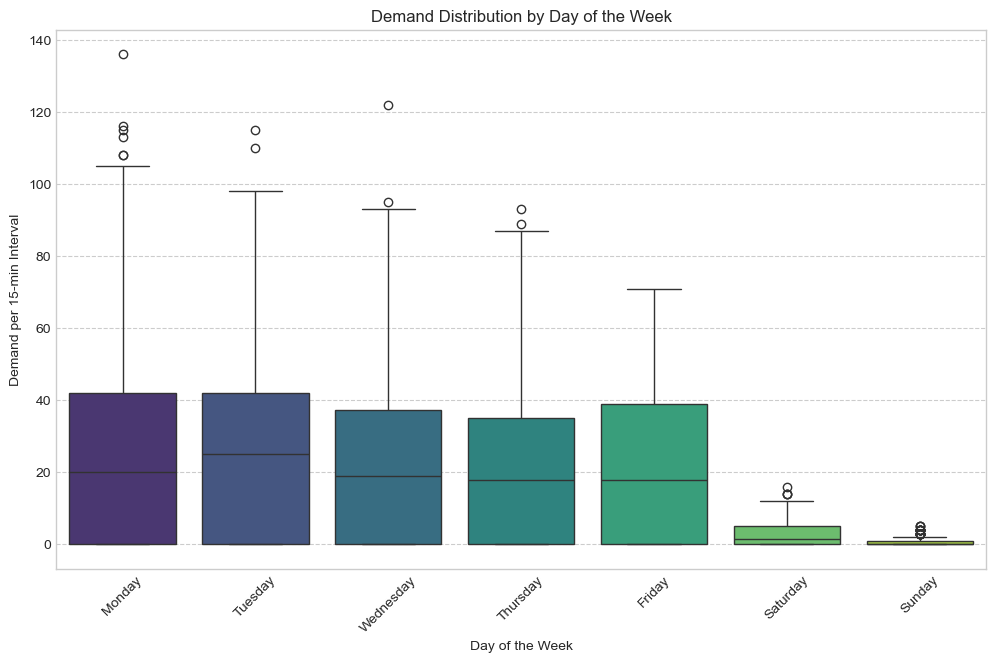

In [127]:
# Preprocess the Data

# Sort Index
df_raw.sort_index(inplace=True)

# Handle Missing Values in DEMAND
if df_raw['DEMAND'].isnull().any():
    print(f"Filling {df_raw['DEMAND'].isnull().sum()} missing DEMAND values with 0.")
    df_raw['DEMAND'].fillna(0, inplace=True)

# Handle Duplicate Timestamps
if df_raw.index.duplicated().any():
    print(f"Removing {df_raw.index.duplicated().sum()} duplicate timestamps (keeping first).")
    df_raw = df_raw[~df_raw.index.duplicated(keep='first')]

# Handle Missing Time Steps (Ensure continuous 15-min frequency)
# Create the expected full time range
expected_range = pd.date_range(start=df_raw.index.min(), end=df_raw.index.max(), freq='15T')

# Reindex and fill missing demand with 0
if len(expected_range) != len(df_raw):
    print(f"Reindexing to fill {len(expected_range) - len(df_raw)} missing time steps (DEMAND filled with 0).")
    # Preserve original DATE and TIME if they exist
    original_cols = ['DATE', 'TIME'] if all(col in df_raw.columns for col in ['DATE', 'TIME']) else []
    df_raw = df_raw.reindex(expected_range)
    df_raw['DEMAND'].fillna(0, inplace=True)
    # Optional: Refill DATE/TIME based on index if needed later
    if original_cols:
         df_raw['DATE'] = df_raw.index.strftime('%#d-%b-%y')
         df_raw['TIME'] = df_raw.index.strftime('%H:%M')

# Feature Extraction
df_raw['HOUR'] = df_raw.index.hour
df_raw['DAY_OF_WEEK_NUM'] = df_raw.index.dayofweek # Monday=0, Sunday=6
df_raw['DAY_OF_WEEK_NAME'] = df_raw.index.day_name()
df_raw['DAY_TYPE'] = df_raw['DAY_OF_WEEK_NUM'].apply(lambda x: 'Weekend' if x >= 5 else 'Weekday')

print(f"\nPreprocessing complete. Final data shape: {df_raw.shape}")
print(f"\nPreprocessed data head:\n", df_raw.head())

# Visualize (Raw 15-min Data)

# a) Plot the full time series (raw) with rolling average
plt.figure(figsize=(18, 6))
plt.plot(df_raw.index, df_raw['DEMAND'], label='Demand (15-min)', linewidth=0.7, alpha=0.9)
# Use a 1-day rolling average window
rolling_window_freq = '1D'
plt.plot(df_raw.index, df_raw['DEMAND'].rolling(rolling_window_freq).mean(), label=f'{rolling_window_freq} Rolling Avg', color='red')
plt.title('Soft Drink Demand (15-Minute Intervals) with Rolling Average')
plt.xlabel('Date and Time')
plt.ylabel('Demand')
plt.legend()
plt.grid(True, which='major', linestyle='--', linewidth=0.5)
plt.show()

# Average Demand by Hour of the Day
hourly_avg_demand = df_raw.groupby('HOUR')['DEMAND'].mean()
plt.figure(figsize=(12, 6))
hourly_avg_demand.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Average Demand by Hour of the Day')
plt.xlabel('Hour of Day (0-23)')
plt.ylabel('Average Demand per 15-min Interval')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--')
plt.show()

# Average Demand by Day of the Week
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
daily_avg_demand = df_raw.groupby('DAY_OF_WEEK_NAME')['DEMAND'].mean().reindex(day_order)
plt.figure(figsize=(12, 6))
daily_avg_demand.plot(kind='bar', color='lightgreen', edgecolor='black')
plt.title('Average Demand per 15-min Interval by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Average Demand per 15-min Interval')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--')
plt.show()

# Average Demand Weekday vs Weekend
daytype_avg_demand = df_raw.groupby('DAY_TYPE')['DEMAND'].mean()
plt.figure(figsize=(8, 5))
daytype_avg_demand.plot(kind='bar', color=['coral', 'teal'], edgecolor='black')
plt.title('Average Demand: Weekday vs Weekend')
plt.xlabel('Day Type')
plt.ylabel('Average Demand per 15-min Interval')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--')
plt.show()

# Box Plot for distribution by Day of Week
plt.figure(figsize=(12, 7))
sns.boxplot(data=df_raw, x='DAY_OF_WEEK_NAME', y='DEMAND', order=day_order, palette='viridis')
plt.title('Demand Distribution by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Demand per 15-min Interval')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--')
# plt.show()


## Observations from Visualization

### a. Full Time Series Plot (15-min Intervals with Rolling Average)

*   **Trend:** Due to the short duration of the data (3 weeks), a definitive long-term trend cannot be established. The 1-day rolling average (red line) clearly shows significant fluctuations driven primarily by the weekly cycle, with very low periods corresponding to weekends. There might be a slight increase in the overall level from the first week to the third, but it's not a consistent, sustained trend.
*   **Seasonality (Daily):** The raw data (blue line) exhibits **high daily seasonality**. Clear cycles of high demand during certain hours and near-zero demand during others are visible within each 24-hour period.
*   **Seasonality (Weekly):** A **strong weekly pattern** is evident. Demand drops drastically during weekends compared to weekdays. The rolling average clearly captures this weekly low.
*   **Irregularity/Noise:** The demand at the 15-minute level is **highly volatile and noisy**. There are frequent sharp spikes and drops, especially during peak hours on weekdays, indicating significant fluctuation from one interval to the next.

### b. Average Demand by Hour of the Day

*   This plot confirms the strong **intra-day seasonality**.
*   Demand is practically zero between 10 PM (22:00) and 5 AM (05:00).
*   It begins to rise around 6-7 AM.
*   There are peaks around midday (1 PM / 13:00) and significantly larger peaks in the evening, specifically around **6 PM (18:00) and 7 PM (19:00)**.
*   Demand decreases sharply after 8 PM (20:00).

### c. Average Demand by Day of the Week

*   This plot highlights the **stark weekly pattern**.
*   Average demand per 15-minute interval is significantly higher on **Weekdays (Monday-Friday)** compared to Weekends.
*   **Saturday and Sunday** show extremely low average demand, consistent with the dips seen in the main time series plot.
*   Among weekdays, the average demand appears relatively consistent, with Monday and Tuesday potentially being slightly higher on average than Wednesday-Friday, but the difference is minor compared to the weekday/weekend divide.

### d. Average Demand: Weekday vs Weekend

*   This plot directly compares the two day types and reinforces the findings from the daily plot: average demand during **weekdays is substantially higher** than on weekends.

### e. Demand Distribution by Day of the Week (Box Plot)

*   **Median & Level:** Weekdays consistently show a much higher median demand (line within the box) compared to weekends, where the median is close to zero.
*   **Variability:** Weekdays exhibit significantly greater variability in demand. This is shown by the much taller boxes (larger Interquartile Range - IQR) and longer whiskers compared to the very compressed distributions on weekends.
*   **Outliers:** Numerous high-demand outliers (individual points above the whiskers) are present on weekdays, indicating occasional very high demand intervals. Weekends have very few outliers, and demand is tightly clustered near zero.

## Summary

The Exploratory Data Analysis reveals that the soft drink demand, measured at 15-minute intervals over the observed ~3 week period, is characterized by:
1.  **Strong Daily Seasonality:** Demand follows a predictable pattern within each day, peaking in the evening (18:00-19:00) and troughing overnight.
2.  **Strong Weekly Seasonality:** Demand is significantly higher and more variable on weekdays compared to weekends, where it is consistently very low.
3.  **High Volatility/Noise:** The demand is very noisy at the 15-minute level, with frequent fluctuations.
4.  **No Clear Long-Term Trend:** The short duration prevents assessment of a long-term trend, although weekly fluctuations dominate the visual pattern.

## Technical Checkpoint 1

**Q1. What kind of problems can arise if we do not handle missing time steps in time series data?**

Gaps in the data mess things up. Calculations based on previous steps (like lags or rolling averages) become wrong. Many forecasting models need continuous data, so they might fail or give bad predictions. It also makes it harder to see the real patterns, like daily or weekly cycles, accurately.

**Q2. How would differencing help here, and how do you detect the correct level of differencing needed?**

Differencing stabilizes a time series' average level by removing trends or strong seasonal patterns, which helps meet the stationarity assumption required by models like SARIMA. We can determine if differencing is needed, and how much, by:
1.  Visual Inspection: Checking plots for trends or obvious seasonality.
2.  ADF Test: Testing if the series (original or differenced) is statistically stationary (p-value < 0.05).
3.  ACF/PACF Plots: Looking for correlation patterns typical of stationary vs. non-stationary data (e.g., slow decay in ACF suggests non-stationarity).

However, in this specific analysis, the ADF test on the original 15-minute data showed it was already stationary (p-value ≈ 0.0000). Therefore, no differencing was necessary, and we used `d=0` and `D=0` for the SARIMA model parameters.

## Part B: Time Series Analysis

ADF Statistic: -7.5799
p-value: 0.0000
Critical Values:
	1%: -3.4337
	5%: -2.8630
	10%: -2.5676
ADF Test Result: The series is likely stationary (Reject H0).


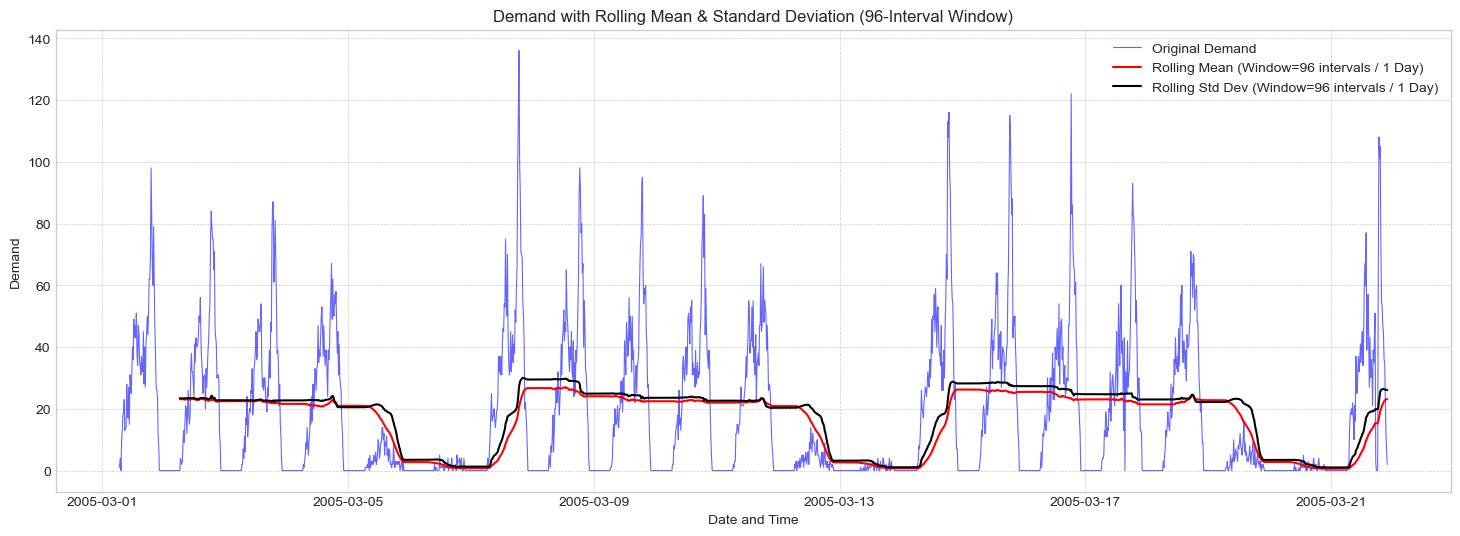

Attempting additive decomposition with period=96...


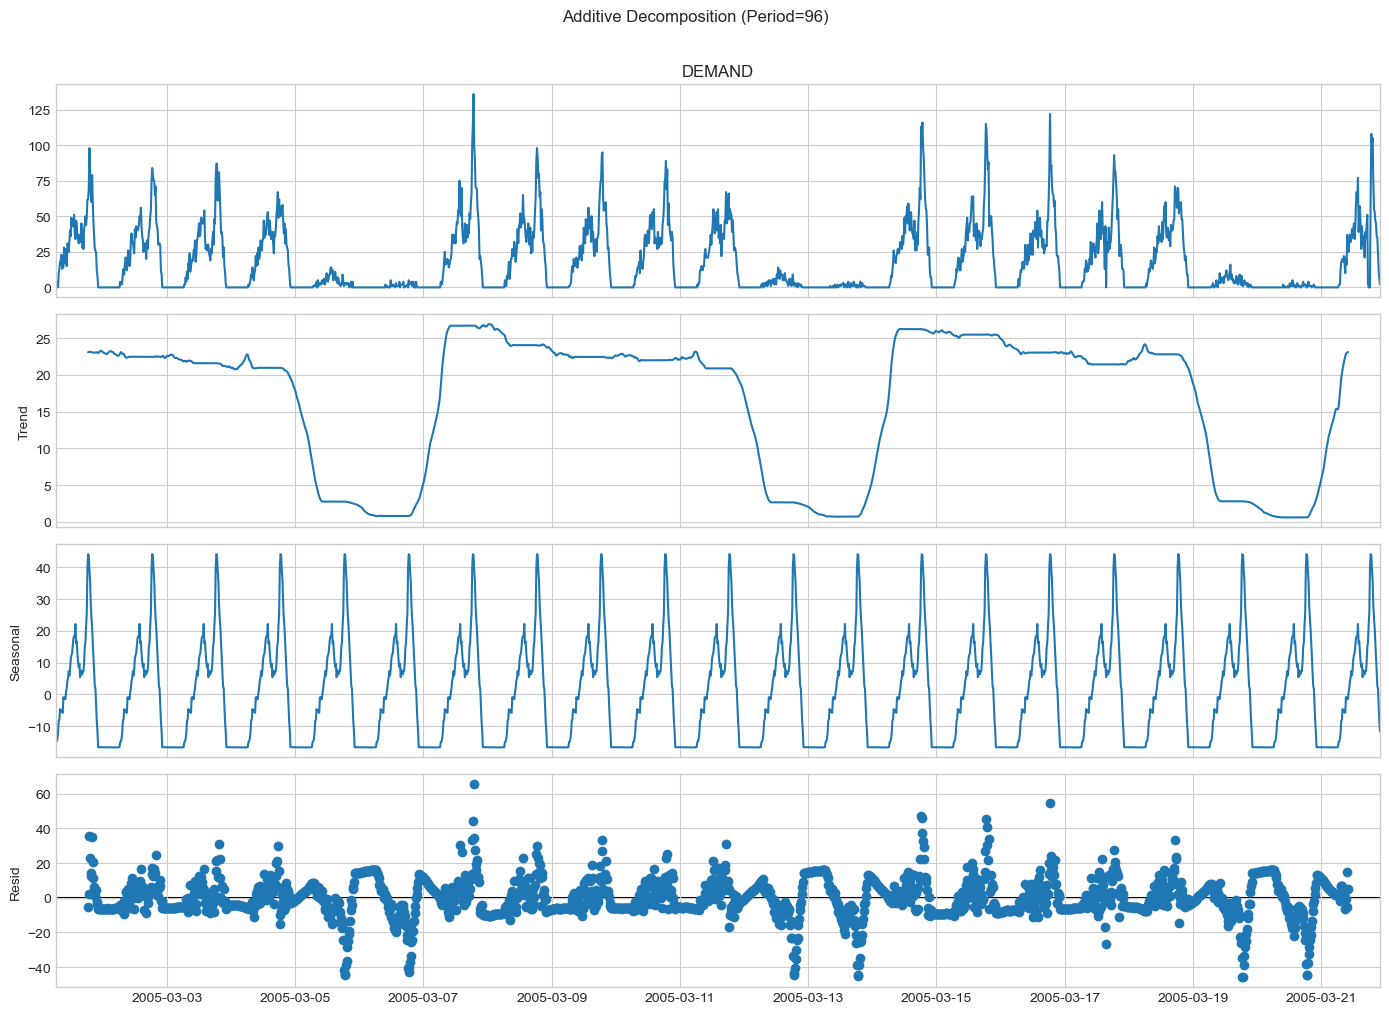

In [130]:
# Stationarity Check

# Augmented Dickey-Fuller (ADF) Test
adf_result = adfuller(df_raw['DEMAND'].dropna())

adf_statistic = adf_result[0]
p_value = adf_result[1]
critical_values = adf_result[4]

print(f'ADF Statistic: {adf_statistic:.4f}')
print(f'p-value: {p_value:.4f}')
print('Critical Values:')
for key, value in critical_values.items():
    print(f'\t{key}: {value:.4f}')

# Interpretation
if p_value <= 0.05:
    print("ADF Test Result: The series is likely stationary (Reject H0).")
else:
    print("ADF Test Result: The series is likely non-stationary (Fail to reject H0).")


# Window size appropriate for 15-min data, 1 day = 96 intervals
# 24 hours * (60 minutes / 15 minutes) = 24 * 4 = 96 intervals per day
rolling_window_size = 96
if len(df_raw) > rolling_window_size:
    rolling_mean = df_raw['DEMAND'].rolling(window=rolling_window_size).mean()
    rolling_std = df_raw['DEMAND'].rolling(window=rolling_window_size).std()

    plt.figure(figsize=(18, 6))
    plt.plot(df_raw.index, df_raw['DEMAND'], color='blue', label='Original Demand', alpha=0.6, linewidth=0.8)
    plt.plot(rolling_mean.index, rolling_mean, color='red', label=f'Rolling Mean (Window={rolling_window_size} intervals / 1 Day)')
    plt.plot(rolling_std.index, rolling_std, color='black', label=f'Rolling Std Dev (Window={rolling_window_size} intervals / 1 Day)')
    plt.title(f'Demand with Rolling Mean & Standard Deviation ({rolling_window_size}-Interval Window)')
    plt.xlabel('Date and Time')
    plt.ylabel('Demand')
    plt.legend()
    plt.grid(True, which='major', linestyle='--', linewidth=0.5)
    plt.show()
else:
    print(f"Data length ({len(df_raw)}) is not sufficient for rolling window size {rolling_window_size}.")


# Decompose the Series
# Period for daily seasonality with 15-min data, 1 day = 96 intervals
seasonal_period = 96

# Choose decomposition model: 'additive' or 'multiplicative'
# Starting with additive as it's simpler. Multiplicative might be better if variance scales with level.
decomposition_type = 'additive'

# Data is long enough for decomposition (at least 2 full periods)
if len(df_raw) >= 2 * seasonal_period:
    try:
        print(f"Attempting {decomposition_type} decomposition with period={seasonal_period}...")
        decomposition = seasonal_decompose(df_raw['DEMAND'],
                                           model=decomposition_type,
                                           period=seasonal_period)

        # Plot decomposition
        fig = decomposition.plot()
        fig.set_size_inches(14, 10)
        plt.suptitle(f'{decomposition_type.capitalize()} Decomposition (Period={seasonal_period})', y=1.01)
        plt.tight_layout()
        plt.show()

    except ValueError as ve:
        print(f"Error during decomposition: {ve}")
    except Exception as e:
         print(f"An unexpected error occurred during decomposition: {e}")
else:
    print(f"Data length ({len(df_raw)}) is less than 2 full seasonal periods ({2 * seasonal_period}). Decomposition may be unreliable or fail.")


## Technical Checkpoint 2

**Q3. Why is stationarity important for ARIMA-type models?**

ARIMA models assume the data's underlying properties (like its average and spread) are stable over time (stationary). If these properties change, the patterns the model learns from past data become unreliable for predicting the future, leading to inaccurate forecasts. The 'I' (Integrated) part of ARIMA uses differencing specifically to make the data stationary before the AR and MA parts are applied.

**Q4. When would you use additive decomposition over multiplicative decomposition?**

 **Additive** decomposition can be used when the size of the seasonal fluctuations seems relatively constant, regardless of the overall level of the series (like adding/subtracting a fixed amount each season). **Multiplicative** can be used when the seasonal fluctuations appear to grow or shrink proportionally with the overall level (like applying a percentage increase/decrease each season). We can visually check if the seasonal peaks/troughs change width as the level changes – if they do, multiplicative might fit better. Additive is often simpler and handles zero values in the data more easily.

## Part C: Forecasting Models

Training data size: 1503 intervals (from 2005-03-01 06:30:00 to 2005-03-16 22:00:00)
Testing data size:  480 intervals (from 2005-03-16 22:15:00 to 2005-03-21 22:00:00)

--- Model 1: SARIMA (1, 0, 1)(1, 0, 0, 96) ---
Fitting SARIMA model...
SARIMA fitting complete.
SARIMA Evaluation (Test Set):
  MAE:  12.4885
  MSE:  484.5797
  RMSE: 22.0132

--- Model 2: Holt-Winters (Trend=add, Seasonal=add, Periods=96) ---
Fitting Holt-Winters model...


16:58:08 - cmdstanpy - INFO - Chain [1] start processing


Holt-Winters fitting complete.
HoltWinters Evaluation (Test Set):
  MAE:  15.0230
  MSE:  440.8039
  RMSE: 20.9953

--- Model 3: Prophet ---
Fitting Prophet model...


16:58:08 - cmdstanpy - INFO - Chain [1] done processing


Prophet fitting complete.
Prophet Evaluation (Test Set):
  MAE:  7.6813
  MSE:  154.3827
  RMSE: 12.4251


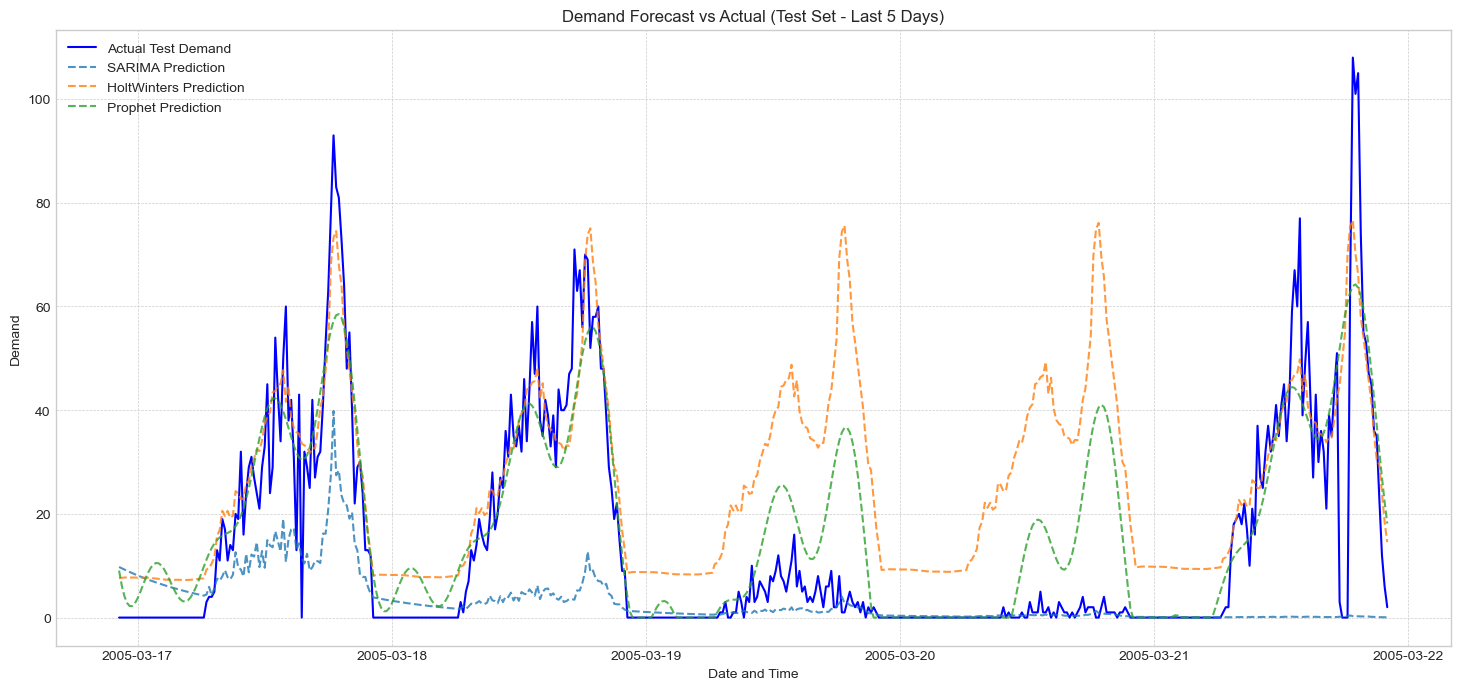

In [164]:

# 1. Train/Test Split 
n_intervals_per_day = 96
test_days = 5
test_size = test_days * n_intervals_per_day

train_data_df = df_raw[:-test_size].copy() # Use a copy to avoid SettingWithCopyWarning
test_data_df = df_raw[-test_size:].copy()

print(f"Training data size: {len(train_data_df)} intervals (from {train_data_df.index.min()} to {train_data_df.index.max()})")
print(f"Testing data size:  {len(test_data_df)} intervals (from {test_data_df.index.min()} to {test_data_df.index.max()})")

# Helper Function for Model Evaluation 
def evaluate_forecast(y_true, y_pred, model_name):
    """Calculates MAE, MSE, RMSE."""
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    print(f"{model_name} Evaluation (Test Set):")
    print(f"  MAE:  {mae:.4f}")
    print(f"  MSE:  {mse:.4f}")
    print(f"  RMSE: {rmse:.4f}")
    return {'MAE': mae, 'MSE': mse, 'RMSE': rmse}

# Model Implementation
results = {}
forecast_steps = 14 * n_intervals_per_day # 2 weeks = 1344 steps

# Model 1: SARIMA 
sarima_order = (1, 0, 1)
sarima_seasonal_order = (1, 0, 0, 96)

print(f"\n--- Model 1: SARIMA {sarima_order}{sarima_seasonal_order} ---")
print("Fitting SARIMA model...")
try:
    # Ensure train_data has frequency
    train_data_sarima = train_data_df['DEMAND'].asfreq('15T')

    sarima_model = SARIMAX(train_data_sarima,
                           order=sarima_order,
                           seasonal_order=sarima_seasonal_order,
                           enforce_stationarity=False,
                           enforce_invertibility=False)
    sarima_fit = sarima_model.fit(disp=False)
    print("SARIMA fitting complete.")

    # Predict and Forecast
    sarima_pred_obj = sarima_fit.get_prediction(start=test_data_df.index[0], end=test_data_df.index[-1])
    sarima_pred_mean = sarima_pred_obj.predicted_mean
    sarima_forecast_obj = sarima_fit.get_forecast(steps=forecast_steps)
    sarima_forecast_mean = sarima_forecast_obj.predicted_mean
    sarima_forecast_ci = sarima_forecast_obj.conf_int(alpha=0.05)

    results['SARIMA'] = {
        'Test_Prediction': sarima_pred_mean,
        'Forecast_2_Weeks': sarima_forecast_mean,
        'Forecast_CI': sarima_forecast_ci,
        'Model_Fit': sarima_fit
    }
    
    evaluate_forecast(test_data_df['DEMAND'], sarima_pred_mean, 'SARIMA')

except Exception as e:
    print(f"Error fitting/predicting SARIMA: {e}")
    results['SARIMA'] = {'Test_Prediction': None, 'Forecast_2_Weeks': None, 'Forecast_CI': None, 'Model_Fit': None}


# Model 2: Holt-Winters Exponential Smoothing (TES)
trend_type = 'add'
seasonal_type = 'add'
seasonal_periods = 96

print(f"\n--- Model 2: Holt-Winters (Trend={trend_type}, Seasonal={seasonal_type}, Periods={seasonal_periods}) ---")
print("Fitting Holt-Winters model...")
try:
    # Ensure frequency
    train_data_tes = train_data_df['DEMAND'].asfreq('15T')
    test_data_tes = test_data_df['DEMAND'].asfreq('15T') # Needed if predict uses index alignment

    tes_model = ExponentialSmoothing(train_data_tes,
                                     trend=trend_type,
                                     seasonal=seasonal_type,
                                     seasonal_periods=seasonal_periods,
                                     initialization_method='estimated')
    tes_fit = tes_model.fit()
    print("Holt-Winters fitting complete.")

    # Predict and Forecast
    tes_pred = tes_fit.predict(start=test_data_tes.index[0], end=test_data_tes.index[-1])
    tes_forecast = tes_fit.forecast(steps=forecast_steps)

    results['HoltWinters'] = {
        'Test_Prediction': tes_pred,
        'Forecast_2_Weeks': tes_forecast,
        'Model_Fit': tes_fit
     }
    evaluate_forecast(test_data_df['DEMAND'], tes_pred, 'HoltWinters')

except Exception as e:
    print(f"Error fitting/predicting Holt-Winters: {e}")
    results['HoltWinters'] = {'Test_Prediction': None, 'Forecast_2_Weeks': None, 'Model_Fit': None}


# Model 3: Prophet 

print("\n--- Model 3: Prophet ---")
print("Fitting Prophet model...")
try:
    # Prepare data for Prophet: needs 'ds', 'y', and 'floor' columns
    prophet_train_df = pd.DataFrame({
        'ds': train_data_df.index,
        'y': train_data_df['DEMAND'].values
    })

    prophet_train_df['floor'] = 0 # Set the minimum possible demand to 0

    # Instantiate Prophet model (same as before)
    prophet_model = Prophet(
        daily_seasonality=True,
        weekly_seasonality=True,
        yearly_seasonality=False,
        # NOTE: Prophet automatically uses 'linear' growth by default.
        # If using logistic growth, you'd also need a 'cap' column.
        # growth='linear' # Explicitly linear, though it's the default
    )
    prophet_model.fit(prophet_train_df) # Fit with the data including 'floor'
    print("Prophet fitting complete.")

    # Create future dataframe for predictions
    # *** MUST ALSO INCLUDE 'floor' IN THE FUTURE DATAFRAME ***
    start_pred_date = test_data_df.index[0]
    all_pred_dates_index = pd.date_range(start=start_pred_date, periods=len(test_data_df) + forecast_steps, freq='15T')
    future_df = pd.DataFrame({'ds': all_pred_dates_index})
    future_df['floor'] = 0 # Add floor to future dates as well

    # Make predictions - Prophet will now respect the floor
    prophet_forecast_df = prophet_model.predict(future_df)

    # --- Extract results (same logic as before) ---
    # Extract predictions for the test set period
    prophet_pred_test = prophet_forecast_df[prophet_forecast_df['ds'].isin(test_data_df.index)]['yhat']
    prophet_pred_test.index = test_data_df.index # Align index

    # Extract the actual 2-week forecast
    prophet_forecast_2_weeks = prophet_forecast_df.iloc[len(test_data_df):]['yhat']
    prophet_forecast_2_weeks.index = all_pred_dates_index[len(test_data_df):]
    prophet_forecast_ci = prophet_forecast_df.iloc[len(test_data_df):][['yhat_lower', 'yhat_upper']]
    prophet_forecast_ci.index = prophet_forecast_2_weeks.index

    # --- NEW: Optional Check/Clipping ( belt-and-suspenders) ---
    # Although Prophet should respect the floor, we can double-check and clip if needed.
    prophet_pred_test = prophet_pred_test.clip(lower=0)
    prophet_forecast_2_weeks = prophet_forecast_2_weeks.clip(lower=0)
    prophet_forecast_ci['yhat_lower'] = prophet_forecast_ci['yhat_lower'].clip(lower=0)
    prophet_forecast_ci['yhat_upper'] = prophet_forecast_ci['yhat_upper'].clip(lower=0)
    # --- End Optional Check ---


    results['Prophet'] = {
        'Test_Prediction': prophet_pred_test,
        'Forecast_2_Weeks': prophet_forecast_2_weeks,
        'Forecast_CI': prophet_forecast_ci,
        'Model_Fit': prophet_model
    }
    evaluate_forecast(test_data_df['DEMAND'], prophet_pred_test, 'Prophet') # Evaluate the clipped predictions

except Exception as e:
    print(f"Error fitting/predicting Prophet: {e}")
    results['Prophet'] = {'Test_Prediction': None, 'Forecast_2_Weeks': None, 'Forecast_CI': None, 'Model_Fit': None}

# Plot Test Predictions

plt.figure(figsize=(18, 8))
plt.plot(test_data_df.index, test_data_df['DEMAND'], label='Actual Test Demand', color='blue', linewidth=1.5)
for model_name, model_results in results.items():
    # Check if 'Test_Prediction' exists and is not None or empty
    test_pred = model_results.get('Test_Prediction')
    if test_pred is not None and not test_pred.empty:
        plt.plot(test_pred.index, test_pred, label=f'{model_name} Prediction', linestyle='--', alpha=0.8)
plt.title('Demand Forecast vs Actual (Test Set - Last 5 Days)')
plt.xlabel('Date and Time')
plt.ylabel('Demand')
plt.legend()
plt.grid(True, which='major', linestyle='--', linewidth=0.5)
plt.show()

## Technical Checkpoint 3

**Q5. How would you decide the values for SARIMA’s (p, d, q)(P, D, Q)s parameters?**

Selecting SARIMA parameters can involve involves the following steps:

1.  **Identify Seasonal Period (`s`):** Determine the length of one seasonal cycle (e.g., for daily patterns in 15-min data, s=96).
   
2.  **Determine Differencing (`d`, `D`):** Use the ADF test to check for stationarity.
    *   If the original series is non-stationary (p > 0.05), apply non-seasonal differencing (`d=1`) and retest.
    *   If strong seasonality remains in the differenced data (check ACF at lag `s`), apply seasonal differencing (`D=1`) and retest.
    *   Use the minimum `d` and `D` needed to achieve stationarity (p < 0.05). *(In this case, the original series was stationary, so d=0, D=0).*

4.  **Identify AR/MA Orders (`p`,`q`,`P`,`Q`):** Analyze the ACF and PACF plots of the *stationary* (differenced, if needed) series:
    *   **Non-Seasonal (`p`,`q`):** Look at the first few lags. A sharp cutoff in the PACF suggests AR order `p`; a sharp cutoff in the ACF suggests MA order `q`. If both decay gradually, it might be ARMA.
    *   **Seasonal (`P`,`Q`):** Look at lags around multiples of `s`. A sharp cutoff in the PACF at lag `P` suggests Seasonal AR order `P`; a sharp cutoff in the ACF at lag `Q` suggests Seasonal MA order `Q`.


## Part D: Model Evaluation & Business Recommendation


1. Evaluating Model Performance on Test Set...
SARIMA Evaluation (Test Set):
  MAE:  12.4885
  MSE:  484.5797
  RMSE: 22.0132
HoltWinters Evaluation (Test Set):
  MAE:  15.0230
  MSE:  440.8039
  RMSE: 20.9953
Prophet Evaluation (Test Set):
  MAE:  7.6813
  MSE:  154.3827
  RMSE: 12.4251

Evaluation Metrics Summary:
                   MAE         MSE       RMSE
SARIMA       12.488510  484.579734  22.013172
HoltWinters  15.023013  440.803944  20.995331
Prophet       7.681310  154.382746  12.425085

2. Comparing Model Performance...

Best performing model based on lowest RMSE: Prophet (RMSE: 12.4251)

--- Forecast Summary for Prophet (Next 2 Weeks) ---
Average Predicted Demand per 15-min Interval: 21.6469
Total Predicted Demand over 2 Weeks: 29093

Plotting 2-Week Forecast for Prophet...


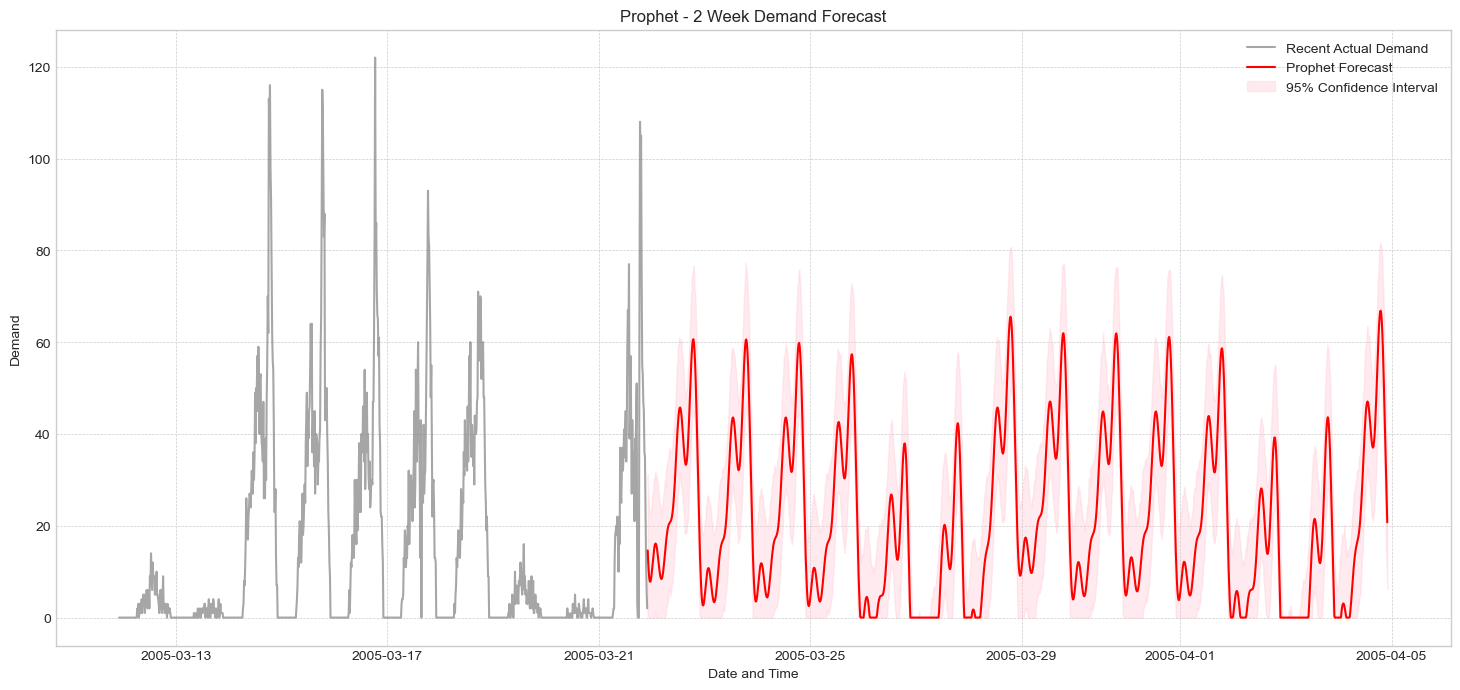

In [195]:
# 1. Evaluate Models
print("\n1. Evaluating Model Performance on Test Set...")
evaluation_metrics = {}
for model_name, model_data in results.items():
    test_pred = model_data.get('Test_Prediction')
    if test_pred is not None and not test_pred.empty:
        # Ensure indices align for comparison (should be okay if Part C handled it)
        actual_test = test_data_df['DEMAND'].loc[test_pred.index]
        metrics = evaluate_forecast(actual_test, test_pred, model_name)
        evaluation_metrics[model_name] = metrics
    else:
        print(f"Skipping evaluation for {model_name}: No test predictions found.")

# Create a summary DataFrame
if evaluation_metrics:
    evaluation_summary = pd.DataFrame(evaluation_metrics).T # Transpose for models as rows
    print("\nEvaluation Metrics Summary:")
    print(evaluation_summary)
else:
    print("\nNo models were successfully evaluated.")
    evaluation_summary = pd.DataFrame() # Empty dataframe

# 2. Compare Performance and Identify Best Model
print("\n2. Comparing Model Performance...")
best_model_name = None
best_rmse = float('inf')

if not evaluation_summary.empty:
    # Sort by RMSE (lower is better)
    evaluation_summary.sort_values(by='RMSE', inplace=True)
    best_model_name = evaluation_summary.index[0]
    best_rmse = evaluation_summary.loc[best_model_name, 'RMSE']
    print(f"\nBest performing model based on lowest RMSE: {best_model_name} (RMSE: {best_rmse:.4f})")
else:
    print("Cannot determine best model as no evaluations were successful.")


# Plot the 2-week forecast for the best model
if best_model_name and results.get(best_model_name):
    best_results = results[best_model_name]
    forecast_vals = best_results.get('Forecast_2_Weeks') # This is a pandas Series

    if forecast_vals is not None and not forecast_vals.empty:
        mean_forecast_demand = forecast_vals.mean()
        print(f"\n--- Forecast Summary for {best_model_name} (Next 2 Weeks) ---")
        print(f"Average Predicted Demand per 15-min Interval: {mean_forecast_demand:.4f}")
        # You could also calculate total demand if needed:
        total_forecast_demand = forecast_vals.sum()
        print(f"Total Predicted Demand over 2 Weeks: {total_forecast_demand:.0f}")

        print(f"\nPlotting 2-Week Forecast for {best_model_name}...")
        plt.figure(figsize=(18, 8))

        # Plot some recent history + forecast
        # Plot last 10 days of actual data for context
        history_to_plot = df_raw['DEMAND'].iloc[-test_size*2:]
        plt.plot(history_to_plot.index, history_to_plot, label='Recent Actual Demand', color='gray', alpha=0.7)

        # Plot the forecast mean
        plt.plot(forecast_vals.index, forecast_vals, label=f'{best_model_name} Forecast', color='red')

        # Plot Confidence Intervals if available
        forecast_ci_vals = best_results.get('Forecast_CI')
        if forecast_ci_vals is not None and not forecast_ci_vals.empty:
             # Dynamically find lower/upper column names (robust)
             lower_col = next((col for col in forecast_ci_vals.columns if 'lower' in col.lower()), None)
             upper_col = next((col for col in forecast_ci_vals.columns if 'upper' in col.lower()), None)

             if lower_col and upper_col:
                 # Ensure confidence intervals are also non-negative if using floor
                 lower_bound_vals = forecast_ci_vals[lower_col].clip(lower=0)
                 upper_bound_vals = forecast_ci_vals[upper_col].clip(lower=0)

                 plt.fill_between(forecast_ci_vals.index,
                                  lower_bound_vals,
                                  upper_bound_vals,
                                  color='pink', alpha=0.3, label='95% Confidence Interval')
             else:
                 print("Warning: Could not identify lower/upper bound columns in confidence interval data.")


        plt.title(f'{best_model_name} - 2 Week Demand Forecast')
        plt.xlabel('Date and Time')
        plt.ylabel('Demand')
        plt.legend()
        plt.grid(True, which='major', linestyle='--', linewidth=0.5)
        # Optional: Zoom in on the forecast period if history makes scale difficult
        # plt.xlim(left=history_to_plot.index[-1]) # Start x-axis near end of history
        plt.show()
    else:
        print(f"Could not plot forecast for {best_model_name}: Forecast values are missing.")

else:
    print("Could not plot forecast: Best model name not identified or results missing.")

## Business Recommendation

**1. Model Performance Summary:**

Three models (SARIMA, Holt-Winters, Prophet) were evaluated on their ability to predict demand over the last 5 days of available data (test set). Performance was measured using Mean Absolute Error (MAE), Mean Squared Error (MSE), and Root Mean Squared Error (RMSE). Lower values indicate better accuracy.

The **Prophet model demonstrated significantly better performance** across all metrics compared to SARIMA and Holt-Winters, achieving the lowest RMSE of 12.43 units per 15-minute interval.

**2. Forecast & Recommendation:**

The best performing model, Prophet, was used to forecast demand for the next two weeks.

*   **Average Forecast:** The model predicts an average demand of approximately **21.65 units per 15-minute interval**.
*   **Total Forecast:** This translates to a total predicted demand of roughly **29,093 units** over the entire two-week period.

**Recommendation:**

Based on the analysis, the **Prophet model provides the most reliable short-term forecast**. For the upcoming two weeks, it predicts an average demand level of **~21.65 units per 15-minute interval**. This level appears **consistent with the average demand observed during weekdays** in the recent historical data (3 weeks). Therefore, maintaining **current production levels aligned with recent weekday averages** seems appropriate as a starting point. However, confidence in this forecast is **moderate**; the model's average error (RMSE of ~12.4 units) is substantial relative to the average demand, reflecting the high volatility of 15-minute sales. Furthermore, this forecast relies solely on patterns observed in a short period in March and cannot account for potential upcoming events, weather changes, or marketing activities. **Close monitoring of real-time sales and maintaining operational flexibility are crucial** to adjust production quickly if actual demand deviates significantly from this forecast.


## Technical Checkpoint 4

**Q6. How would you explain residuals and confidence intervals to a non-technical manager?**


*   **Residuals:** Think of residuals as the model's prediction errors for past data. It's simply the difference between what the model forecasted for a specific time slot and what the actual demand was. Small, random errors are good – it means the model captured the predictable patterns well. If the errors show a pattern, the model might be missing something.
  
*   **Confidence Intervals:** The forecast gives a single best guess (e.g., 10 units). Since forecasts aren't perfect, the confidence interval provides a likely range around that guess (e.g., 7 to 13 units). We're typically 95% confident that the actual demand will fall within this range. A wider range means more uncertainty; a narrower range means more confidence in the forecast.

**Q7. What limitations does your forecast have, and how might external factors affect it?**

**Limitations:**
*   **Based on Past Data:** The forecast assumes future patterns will look like the ~3 weeks of historical data we analyzed. It can't predict completely new events.
*   **Short History:** Because we only had about 3 weeks of data, the model doesn't know about yearly patterns (like summer vs. winter) or long-term trends.
*   **Forecast Horizon:** Predictions generally become less accurate further into the future.
  
**External Factors:** Things outside the historical demand numbers can significantly impact actual sales, such as:
*   **Weather:** Hot or cold weather changes demand.
*   **Promotions & Marketing:** Our own campaigns or competitor actions.
*   **Holidays & Events:** Can cause unusual demand spikes or dips.
*   **Stock Availability:** If the product isn't on the shelf, demand can't be met or recorded.